In [1]:
!pip install pydot



In [2]:
!pip install graphviz

In [3]:
#first import libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
import os

#tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model
#import time
import time

In [4]:
#get the images directory
image_dir = os.getcwd() + '/images/finding_wally'

#get the background and wally image directory
background_dir = image_dir + '/wheres_wally.jpg'
wally_dir = image_dir + '/wally.png'

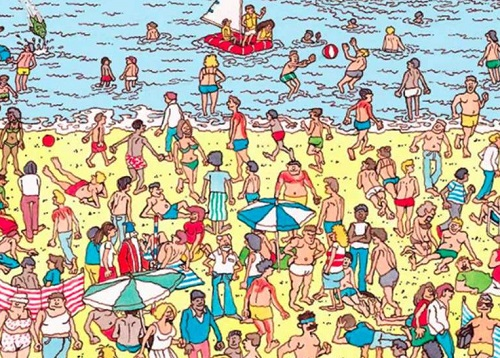

In [5]:
#background image
background_im = Image.open(background_dir)
background_im

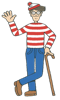

In [6]:
#image of wally
wally_im = Image.open(wally_dir)
wally_im = wally_im.resize((60, 100))
wally_im

<u> **Generating sample images** </u>

In [7]:
#create a function to generate images
def generate_sample_image():

    #background image
    background_im = Image.open(background_dir)
    background_im = background_im.resize((500, 350))
    #background_im = Image.new("RGB", (500, 350), (255, 255, 255))

    #wally
    wally_im = Image.open(wally_dir)
    wally_im = wally_im.resize((60, 100))

    #select x and y coordinates randomly we'll select between (0, 430) and (0, 250)
    col = np.random.randint(0, 410)
    row = np.random.randint(0, 230)

    background_im.paste(wally_im, (col, row), mask = wally_im)

    return np.array(background_im).astype('uint8'), (col, row), 1, 'wally'

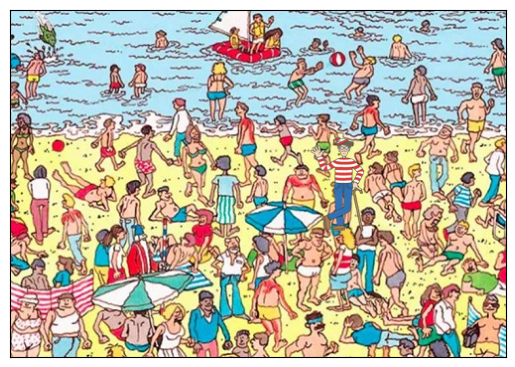

In [8]:
#generate the sample image and plot
sample_im, pos, _, cat = generate_sample_image()
plt.imshow(sample_im)
plt.xticks([])
plt.yticks([])
plt.show()

In [9]:
def plot_bounding_box(image, gt_coords, pred_coords = None):

    #convert image to array
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    draw.rectangle((gt_coords[0], gt_coords[1], gt_coords[0] + 60, gt_coords[1] + 100), outline = 'green', width = 5)

    if pred_coords:

        draw.rectangle((pred_coords[0], pred_coords[1], pred_coords[0] + 60, pred_coords[1] + 100), outline = 'red', width = 5)

    return image

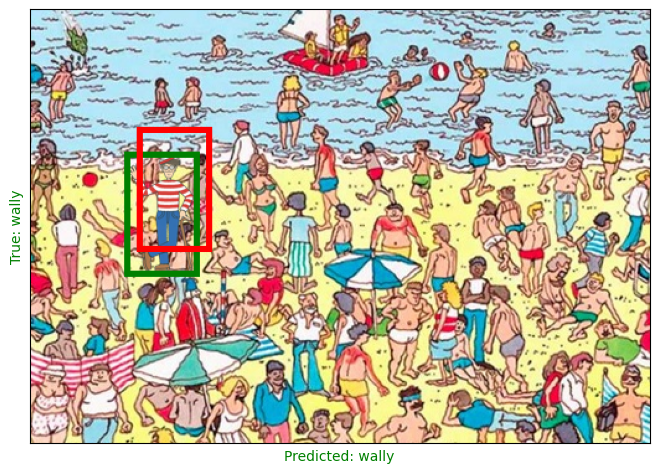

In [10]:
#generate an example image
sample_im, pos, _, cat = generate_sample_image()

#get image with bounding box
im = plot_bounding_box(sample_im, pos, (pos[0] + 10, pos[1] -20))

plt.figure(figsize = (8, 8))
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.xlabel('Predicted: ' + cat, color = 'green')
plt.ylabel('True: ' + cat, color = 'green' )
plt.show()

In [11]:
#data generator function
def generate_data(batch_size = 16):

    while True:

        #create empty arrays for the generated data
        x_batch = np.zeros((batch_size, 350, 500, 3))
        y_batch = np.zeros((batch_size, 1))
        boundary_box = np.zeros((batch_size, 2))

        for i in range(batch_size):

            #generate an example image
            sample_im, pos, person, _ = generate_sample_image()

            #put the images to the arrays
            x_batch[i] = sample_im/255 #normalize
            y_batch[i] = person
            boundary_box[i, 0] = pos[0]
            boundary_box[i, 1] = pos[1]

        yield {'image': x_batch} , {'class': y_batch, 'box': boundary_box}

In [12]:
#create the model
def convolutional_block(inputs):

    x = tf.keras.layers.Conv2D(16, 3, padding = 'same', activation = 'relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)

    x = tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)

    x = tf.keras.layers.Conv2D(64, 6, padding = 'valid', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)

    x = tf.keras.layers.Conv2D(64, 6, padding = 'valid', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)

    return x

def regression_block(x):

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(2, name = 'box')(x)

    return x

def classification_block(x):

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'class')(x)

    return x

In [13]:
#create the model instance
inputs = tf.keras.Input((350, 500, 3))

#conv block
x = convolutional_block(inputs)

#outputs
box_output = regression_block(x)
class_output = classification_block(x)

#model instance
model = tf.keras.Model(inputs = inputs, outputs = [class_output, box_output])

In [ ]:
#model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 350, 500,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 350, 500,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 350, 500,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 175, 250,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 175, 250,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 175, 250,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 87, 125,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 82, 120,   │     73,792 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 82, 120,   │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 41, 60,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 36, 55,    │    147,520 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 36, 55,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 18, 27,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 31104)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 31104)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1024)      │ 31,851,520 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │ 31,851,520 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    524,800 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 64,981,283 (247.88 MB)

 Trainable params: 64,980,931 (247.88 MB)

 Non-trainable params: 352 (1.38 KB)

In [14]:
#custom function to visualize the predictions after epochs
def test_model():

    fig, ax = plt.subplots(1, 3, figsize = (15, 5))

    for i in range(3):

        #get sample image
        sample_im, pos, _, wally = generate_sample_image()
        sample_image_normalized = sample_im.reshape(1, 350, 500, 3)/255
        predicted_class, predicted_box = model.predict(sample_image_normalized)

        predicted_class = 'wally' if predicted_class > 0.5 else 'Not wally'

        #assign color
        col = 'green' if (predicted_class == cat) else 'red'

        #get bounding boxes
        im = plot_bounding_box(sample_im, pos, (predicted_box[0][0], predicted_box[0][1]))

        #plot image
        ax[i].imshow(im)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_ylabel('True: ' + cat, color = 'green')
        ax[i].set_xlabel('Predicted: ' + predicted_class, color = col)

    plt.show()

class VisCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs = None):

        if epoch % 2 == 0:

            test_model()

#learning rate scheduleer
def lr_schedule(epoch, lr):

    if (epoch + 1) % 5 == 0:

        lr *= 0.2

    return max(lr, 3e-7)

In [15]:
#compile
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = {'class': 'binary_crossentropy', 'box': 'mse'}, \
              metrics = {'class': 'accuracy', 'box': 'mse'})

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 350, 500,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 350, 500,  │        448 │ image_input[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 350, 500,  │         64 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 175, 250,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 175, 250,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 175, 250,  │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 87, 125,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 82, 120,   │     73,792 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 82, 120,   │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 41, 60,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 36, 55,    │    147,520 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 36, 55,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 18, 27,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 31104)     │          0 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 31104)     │          0 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1024)      │ 31,851,520 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1024)      │ 31,851,520 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 512)       │    524,800 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 64,981,283 (247.88 MB)

 Trainable params: 64,980,931 (247.88 MB)

 Non-trainable params: 352 (1.38 KB)

Epoch 1/10


d:\Dissertation\2431303\.venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: image_input
Received: inputs=['Tensor(shape=(None, 350, 500, 3))']
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/stepp - box_output_loss: 7140.4277 - box_output_mse: 7140.4277 - class_output_accuracy: 0.9968 - class_output_loss: 0.0193 - loss: 7140.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


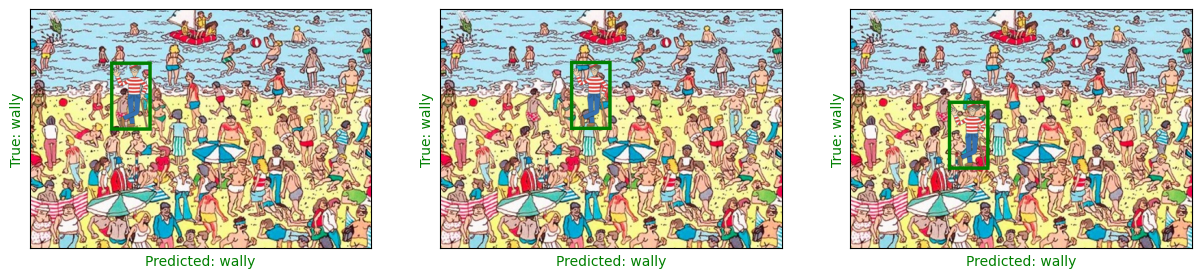

100/100 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - box_output_loss: 2665.6079 - box_output_mse: 2665.6079 - class_output_accuracy: 0.9994 - class_output_loss: 0.0037 - loss: 2665.6116 - learning_rate: 0.0010
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - box_output_loss: 87.7339 - box_output_mse: 87.7339 - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 87.7339 - learning_rate: 0.0010
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/stepep - box_output_loss: 109.2075 - box_output_mse: 109.2075 - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 109.207
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


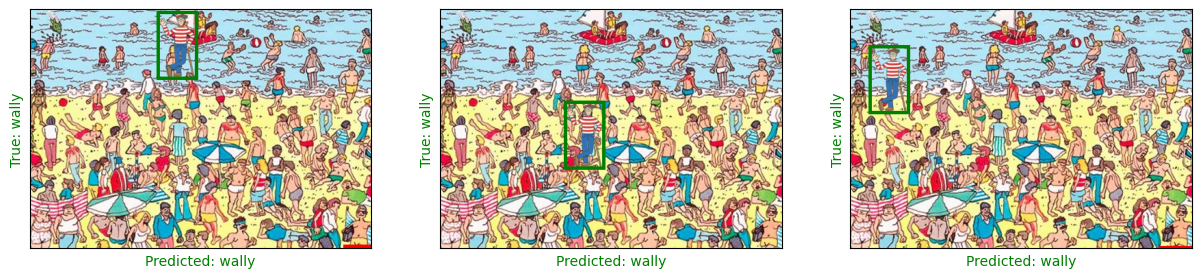

100/100 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - box_output_loss: 104.8151 - box_output_mse: 104.8151 - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 104.8151 - learning_rate: 0.0010
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - box_output_loss: 64.5811 - box_output_mse: 64.5811 - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 64.5811 - learning_rate: 0.0010
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/stepep - box_output_loss: 25.1739 - box_output_mse: 25.1739 - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 25.173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


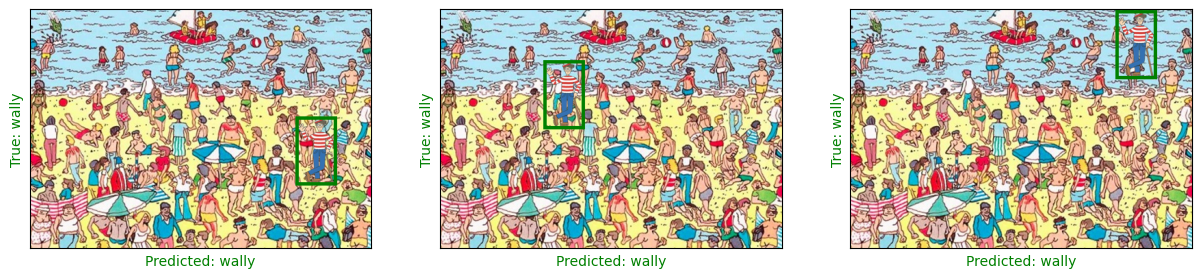

100/100 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - box_output_loss: 19.0484 - box_output_mse: 19.0484 - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 19.0484 - learning_rate: 2.0000e-04
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - box_output_loss: 15.4218 - box_output_mse: 15.4218 - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 15.4218 - learning_rate: 2.0000e-04
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/stepep - box_output_loss: 15.1820 - box_output_mse: 15.1820 - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 15.182
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


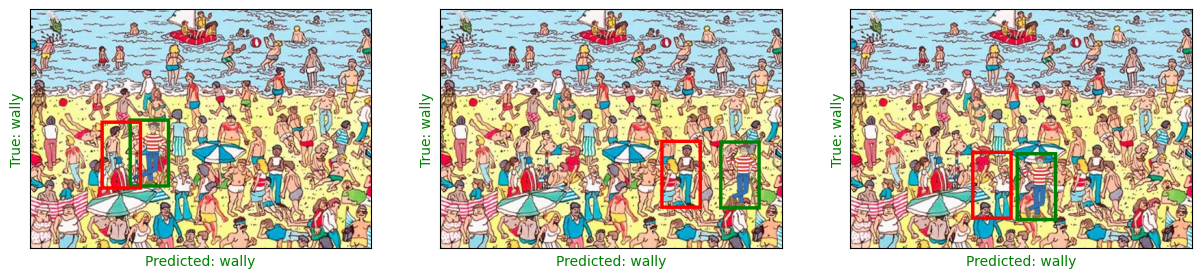

100/100 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - box_output_loss: 14.9449 - box_output_mse: 14.9449 - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 14.9449 - learning_rate: 2.0000e-04
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - box_output_loss: 9.6799 - box_output_mse: 9.6799 - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 9.6799 - learning_rate: 2.0000e-04
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/stepep - box_output_loss: 11.3208 - box_output_mse: 11.3208 - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 11.320
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


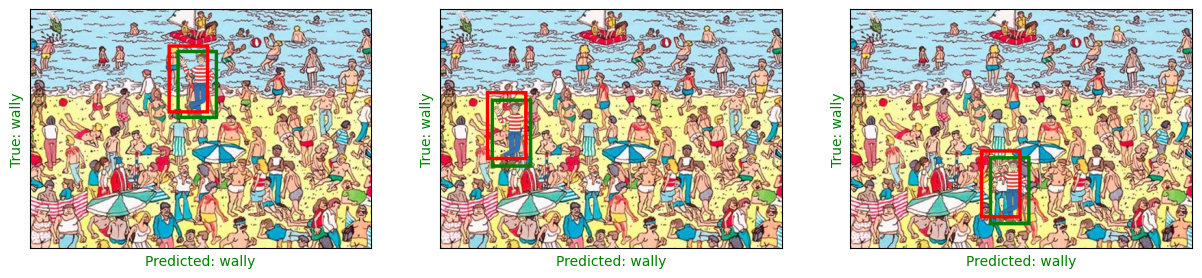

100/100 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - box_output_loss: 15.2183 - box_output_mse: 15.2183 - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 15.2183 - learning_rate: 2.0000e-04
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - box_output_loss: 8.1176 - box_output_mse: 8.1176 - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 8.1176 - learning_rate: 4.0000e-05


In [16]:

# Data generator function
def generate_data(batch_size=16):
    while True:
        # Create empty arrays for the generated data
        x_batch = np.zeros((batch_size, 350, 500, 3))
        y_batch = np.zeros((batch_size, 1))
        boundary_box = np.zeros((batch_size, 2))

        for i in range(batch_size):
            # Generate an example image
            sample_im, pos, person, cat = generate_sample_image()

            # Populate the arrays
            x_batch[i] = sample_im / 255  # Normalize
            y_batch[i] = person
            boundary_box[i, 0] = pos[0]
            boundary_box[i, 1] = pos[1]

        yield {'image_input': x_batch}, {'class_output': y_batch, 'box_output': boundary_box}

# Define the convolutional block
def convolutional_block(inputs):
    x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)

    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)

    x = tf.keras.layers.Conv2D(64, 6, padding='valid', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)

    x = tf.keras.layers.Conv2D(64, 6, padding='valid', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)

    return x

# Define regression block
def regression_block(x):
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(2, name='box_output')(x)
    return x

# Define classification block
def classification_block(x):
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid', name='class_output')(x)
    return x

# Create the model
inputs = tf.keras.Input((350, 500, 3), name="image_input")

# Convolutional block
x = convolutional_block(inputs)

# Outputs
box_output = regression_block(x)
class_output = classification_block(x)

# Model instance
model = tf.keras.Model(inputs=inputs, outputs=[class_output, box_output])

# Model summary
model.summary()

# Custom function to visualize predictions
def test_model():
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    for i in range(3):
        # Generate sample image
        sample_im, pos, _, cat = generate_sample_image()
        sample_image_normalized = sample_im.reshape(1, 350, 500, 3) / 255
        predicted_class, predicted_box = model.predict(sample_image_normalized)

        predicted_class = "wally" if predicted_class > 0.5 else "Not wally"
        col = "green" if predicted_class == cat else "red"

        # Bounding box
        im = plot_bounding_box(sample_im, pos, (predicted_box[0][0], predicted_box[0][1]))

        # Plot image
        ax[i].imshow(im)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_ylabel('True: ' + cat, color='green')
        ax[i].set_xlabel('Predicted: ' + predicted_class, color=col)

    plt.show()

# Visualization callback
class VisCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 2 == 0:
            test_model()

# Learning rate scheduler
def lr_schedule(epoch, lr):
    if (epoch + 1) % 5 == 0:
        lr *= 0.2
    return max(lr, 3e-7)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss={'class_output': 'binary_crossentropy', 'box_output': 'mse'},
    metrics={'class_output': 'accuracy', 'box_output': 'mse'}
)

# Timing
tick = time.time()

# Fit the model
hist = model.fit(
    generate_data(),
    epochs=10,
    steps_per_epoch=100,
    callbacks=[
        VisCallback(),
        tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)

tock = time.time()

In [17]:
#print time taken
print('Took {} minutes to run finish training 10 epochs'.format(np.round((tock - tick)/60, 2)))

Took 25.05 minutes to run finish training 10 epochs


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


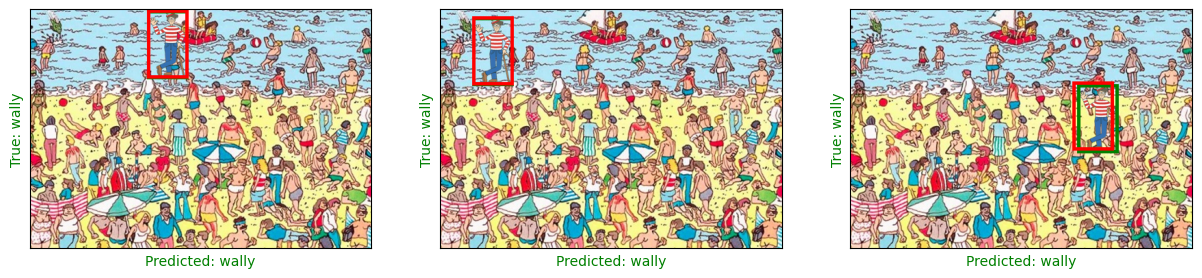

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


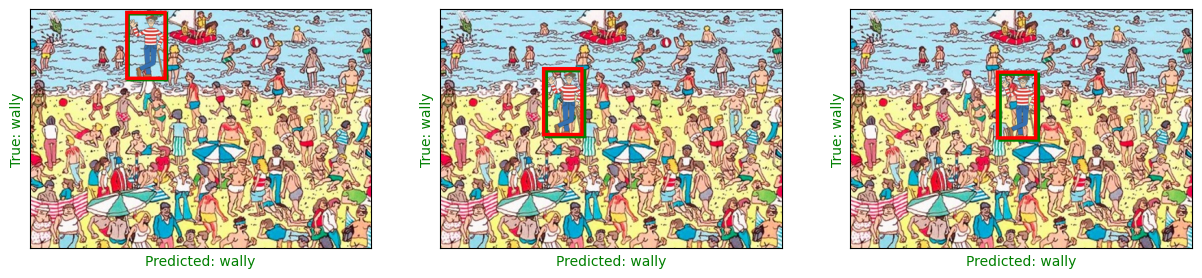

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


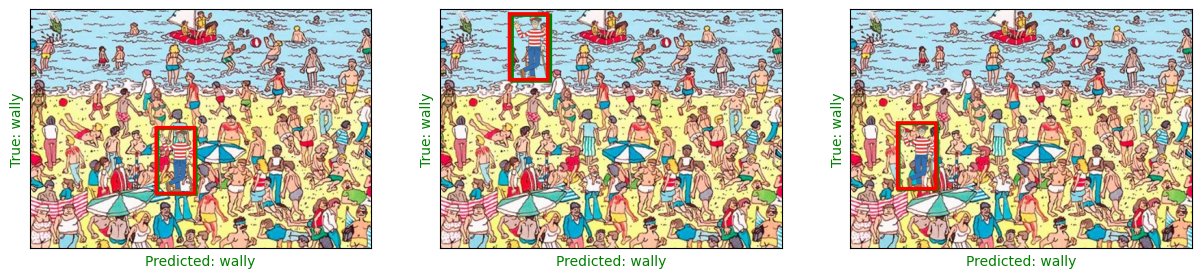

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


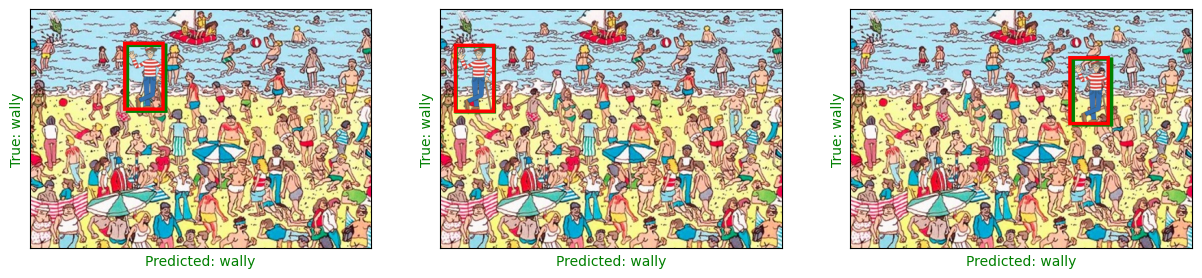

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


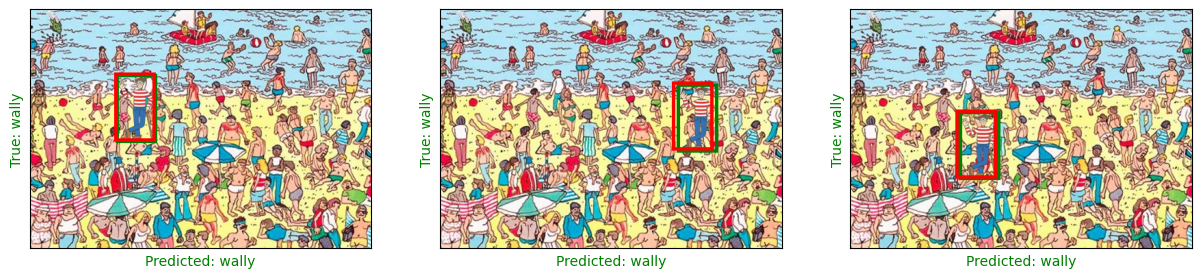

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


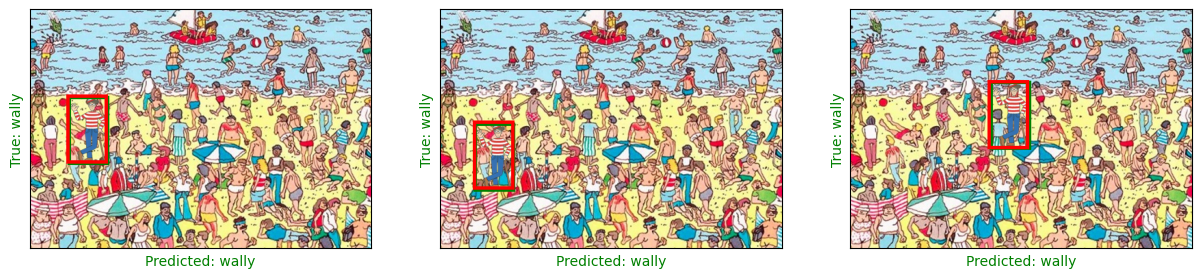

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


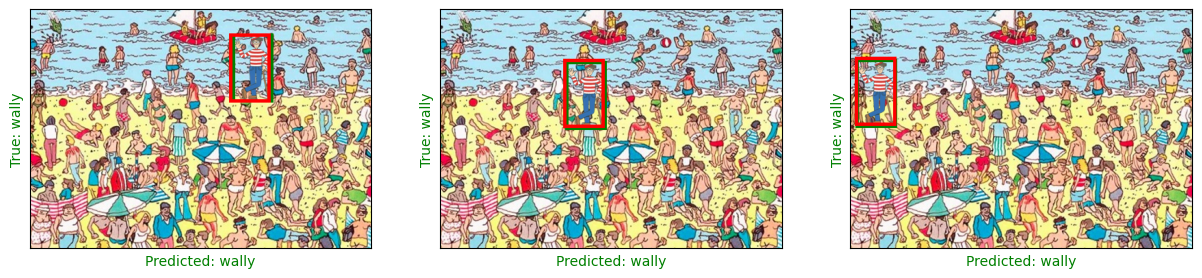

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


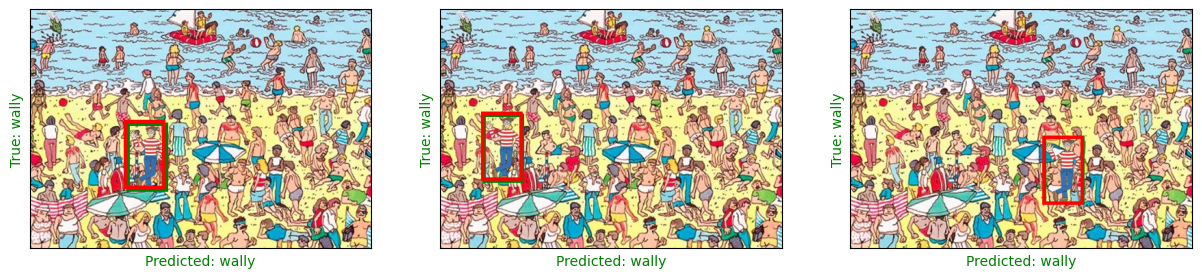

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


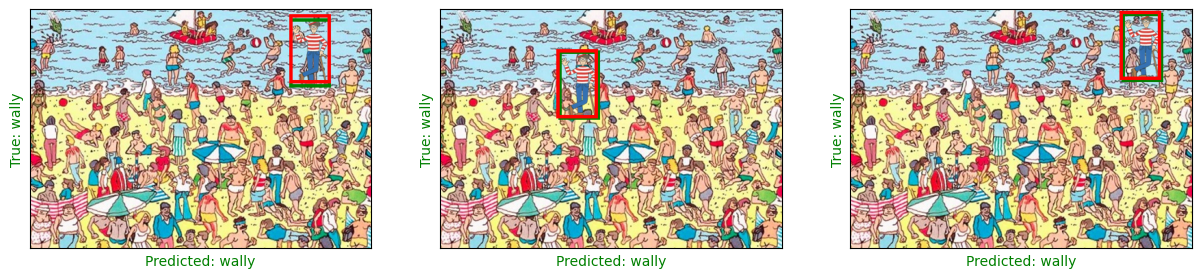

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


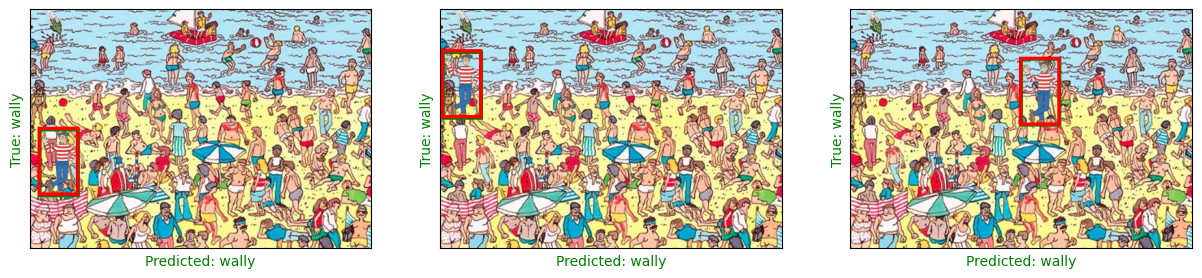

In [18]:
#test again in the end a couple of times
for i in range(10):
    test_model()

In [ ]:
import numpy as np
import tensorflow as tf
import random
from PIL import Image, ImageDraw
import os

# Image paths (set these according to your setup)
image_dir = os.getcwd() + '/images/finding_wally'
background_path = os.path.join(image_dir, 'wheres_wally.jpg')
wally_path = os.path.join(image_dir, 'wally.png')

# Load and resize images
def load_assets():
    bg = Image.open(background_path).resize((500, 350))
    wally = Image.open(wally_path).resize((60, 100))
    return bg, wally,

bg_img, wally_img, = load_assets()

# Generate an image with wally randomly
def generate_sample_image():
    img = bg_img.copy()
    col = random.randint(0, 440)
    row = random.randint(0, 250)
    img.paste(wally_img, (col, row), mask=wally_img)
    return np.array(img), (col, row), 'wally'

# Define custom environment
class wallyEnv:
    def __init__(self):
        self.patch_w, self.patch_h = 60, 100
        self.grid_w, self.grid_h = 500 // 60, 350 // 100
        self.max_steps = 50
        self.reset()

    def reset(self):
        self.img, self.true_pos, self.target = generate_sample_image()
        self.current_row = random.randint(0, self.grid_h - 1)
        self.current_col = random.randint(0, self.grid_w - 1)
        self.steps = 0
        return self.get_state()

    def get_state(self):
        x = self.current_col * self.patch_w
        y = self.current_row * self.patch_h
        patch = self.img[y:y+self.patch_h, x:x+self.patch_w]
        return patch / 255.0

    def step(self, action):
        done = False
        reward = -0.05
        if action == 0 and self.current_col > 0: self.current_col -= 1
        elif action == 1 and self.current_col < self.grid_w - 1: self.current_col += 1
        elif action == 2 and self.current_row > 0: self.current_row -= 1
        elif action == 3 and self.current_row < self.grid_h - 1: self.current_row += 1
        elif action == 4:  # terminate
            pred_x = self.current_col * self.patch_w
            pred_y = self.current_row * self.patch_h
            iou = self.calculate_iou((pred_x, pred_y), self.true_pos)
            reward = 10 if iou > 0.3 else -1
            done = True
        self.steps += 1
        if self.steps >= self.max_steps:
            done = True
        return self.get_state(), reward, done

    def calculate_iou(self, pred, true):
        pred_box = [pred[0], pred[1], pred[0]+60, pred[1]+100]
        true_box = [true[0], true[1], true[0]+60, true[1]+100]
        xA = max(pred_box[0], true_box[0])
        yA = max(pred_box[1], true_box[1])
        xB = min(pred_box[2], true_box[2])
        yB = min(pred_box[3], true_box[3])
        interArea = max(0, xB - xA) * max(0, yB - yA)
        boxAArea = 60 * 100
        boxBArea = 60 * 100
        iou = interArea / float(boxAArea + boxBArea - interArea)
        return iou

# DQN agent
class DQNAgent:
    def __init__(self, action_size):
        self.action_size = action_size
        self.memory = []
        self.model = self.build_model()
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = 32

    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(100, 60, 3)),
            tf.keras.layers.Conv2D(32, 3, activation='relu'),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Conv2D(64, 3, activation='relu'),
            tf.keras.layers.MaxPool2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(self.action_size)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.randint(0, self.action_size - 1)
        q_vals = self.model.predict(state[np.newaxis, ...], verbose=0)
        return np.argmax(q_vals[0])

    def remember(self, s, a, r, s_, done):
        self.memory.append((s, a, r, s_, done))
        if len(self.memory) > 2000:
            self.memory.pop(0)

    def replay(self):
        if len(self.memory) < self.batch_size: return
        minibatch = random.sample(self.memory, self.batch_size)
        for s, a, r, s_, done in minibatch:
            target = r
            if not done:
                target += self.gamma * np.amax(self.model.predict(s_[np.newaxis, ...], verbose=0)[0])
            target_f = self.model.predict(s[np.newaxis, ...], verbose=0)
            target_f[0][a] = target
            self.model.fit(s[np.newaxis, ...], target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Training loop
env = wallyEnv()
agent = DQNAgent(action_size=5)

episodes = 10000
for e in range(episodes):
    state = env.reset()
    total_reward = 0
    for time_step in range(50):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.replay()
        state = next_state
        total_reward += reward
        if done:
            break
    # Print episode information only once at the end of the episode
    print(f"Episode {e+1}/{episodes}, Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")

Episode 1/10, Reward: -1.05, Epsilon: 1.00
Episode 2/10, Reward: -1.15, Epsilon: 1.00
Episode 3/10, Reward: -1.50, Epsilon: 1.00
Episode 4/10, Reward: -1.00, Epsilon: 1.00
Episode 5/10, Reward: -1.20, Epsilon: 1.00
Episode 6/10, Reward: -1.00, Epsilon: 1.00
Episode 7/10, Reward: -1.00, Epsilon: 1.00
Episode 8/10, Reward: -1.15, Epsilon: 1.00
Episode 9/10, Reward: -1.05, Epsilon: 1.00
Episode 10/10, Reward: -1.10, Epsilon: 0.99
